In [1]:
!pip install -q numpyro arviz


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap
import numpy as np

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

### Code 4.1

Normal by addition. 

In [6]:
# For each person, we generate a random 16-dimensional vector between -1 and 1, and we sum that vector for 1000 times
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)
pos

Array([ 5.61132908e-01, -1.17247915e+00,  1.55752277e+00,  8.88576508e-01,
       -1.73665762e+00, -4.03293037e+00, -1.50178623e+00, -4.99936771e+00,
       -2.07851458e+00,  2.63417006e+00, -3.30771017e+00, -3.48190999e+00,
       -2.09757566e-01,  1.24740052e+00,  3.14440107e+00, -5.62715340e+00,
       -1.63036513e+00, -1.44266653e+00,  2.78281832e+00,  8.87007713e-02,
       -3.05867505e+00, -8.59049082e-01, -7.62514114e-01,  1.87012672e+00,
        1.87871337e+00, -4.81376886e-01, -2.89399385e-01,  4.47687531e+00,
       -2.28968930e+00, -2.97234774e-01, -1.25017858e+00,  2.10999274e+00,
        7.24246502e-01,  1.94145203e+00,  2.33035612e+00,  4.94107962e+00,
       -2.09135389e+00, -6.91251993e-01, -1.66530514e+00, -8.09232235e-01,
        5.16528606e-01, -1.30555153e-01,  2.44336462e+00,  2.82048225e+00,
        8.73649120e-02, -2.50676084e+00, -5.88288546e-01, -5.60471916e+00,
       -1.39117813e+00,  3.60539579e+00, -2.02318692e+00,  6.25504971e-01,
        1.56700587e+00,  

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

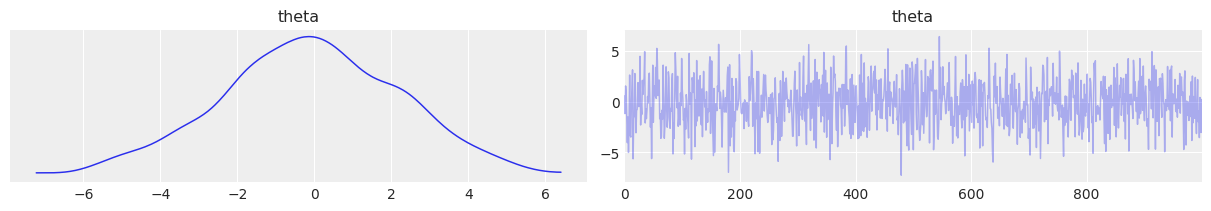

In [12]:
pos_np = np.array(pos)
az.plot_trace(az.from_dict(posterior={"theta": pos_np}))

### Code 4.2

Normal by multiplication.

In [22]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

Array(1.7294353, dtype=float32)

### Code 4.3

When running the below code, we will see how `growth` fits a normal distribution by comparing it to a specific Normal distribution with the same mean and std as `growth`.

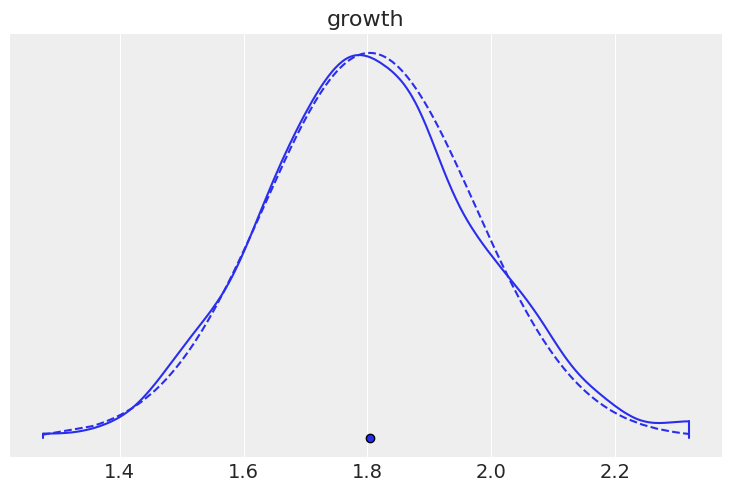

In [28]:
# The axis=-1 instructs jax to sum over the last axis of the NxM array (that is,
# the columns M) -- in the case below, that is 12
growth = jnp.prod(
    1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), axis=-1
)


def plot_densities(growth1, growth2):
    az.plot_density({"growth": growth1}, hdi_prob=1)
    x = jnp.sort(growth1)
    plt.plot(x, growth2, "--")
    plt.show()


growth2 = jnp.exp(dist.Normal(jnp.mean(growth), jnp.std(growth)).log_prob(x))
plot_densities(growth, growth2)

### Code 4.4

Before we saw how normal distributions arise from summing random fluctuations. But, in the previous example of the alleles, each locus is multiplied by the effects of the other loci, not summed. So, what is going on?

The answer is simple: multiplying small numbers is approximately the same as addition. 

array([[<Axes: title={'center': 'big'}>,
        <Axes: title={'center': 'small'}>]], dtype=object)

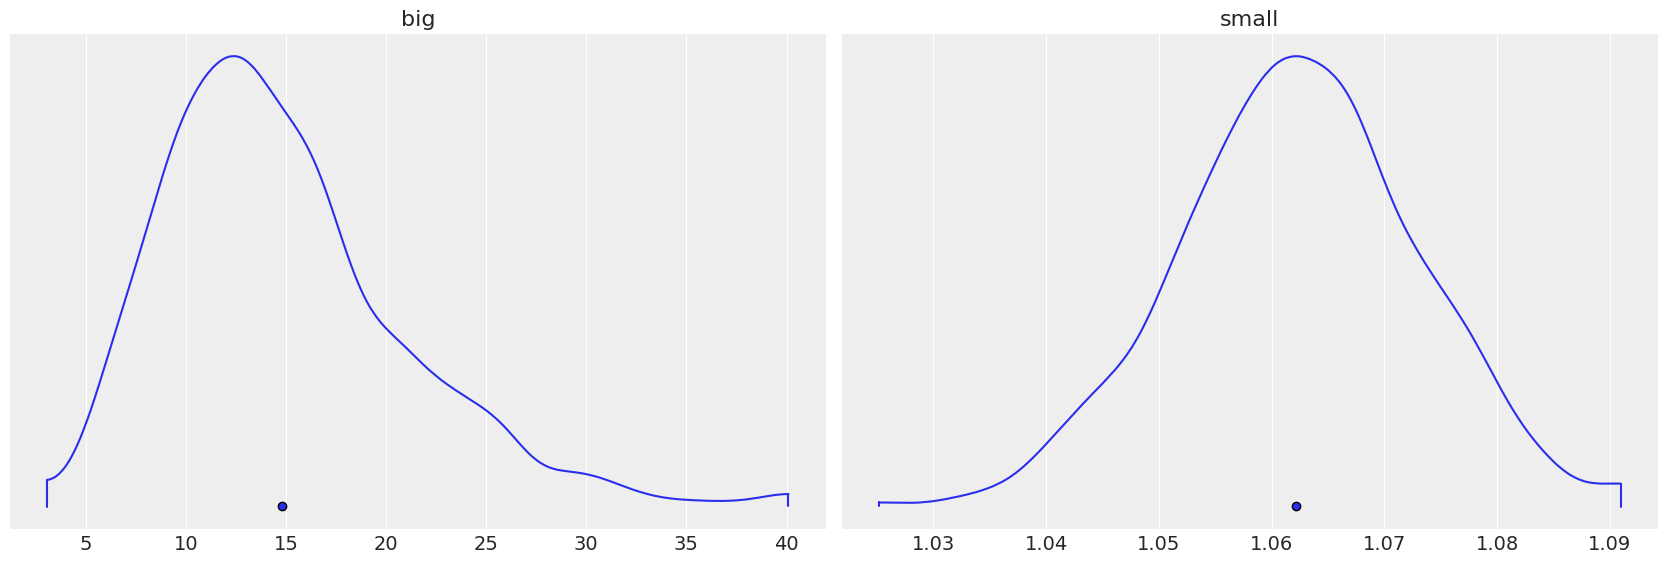

In [31]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)

az.plot_density({"big": big, "small": small}, hdi_prob=1)

### Code 4.5

Normal by log-multiplication.

Large deviates that are multiplied together do not produce Gaussian distributions, but they tend to produce Gaussian distributions on the log scale.

array([[<Axes: title={'center': 'log_big'}>]], dtype=object)

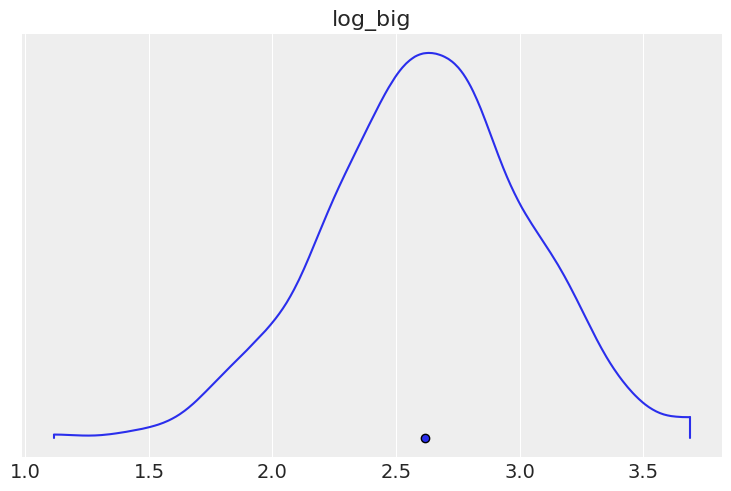

In [32]:
log_big = jnp.log(big)
az.plot_density({"log_big": log_big}, hdi_prob=1)

### Code 4.6

In [33]:
w = 6
n = 9
p_grid = jnp.linspace(0, 1, num=100)
binom_grid = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = binom_grid * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / posterior.sum()

### Code 4.7

In [36]:
d = pd.read_csv("data/Howell1.csv", sep=";")

In [37]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.9

In [38]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05

